# Data Encoding

This notebook contains the code related to the data-encoding project. More details are in the `README.md`. Much of the below language is taken directly from the authors of the paper given in the `README.md`.

## Notation

$D=(x^d, y^d)_{d=1}^m$ represents a classical data set, where $m$ is the number of samples, $x^d \in \mathbb{R}^N$ is an $N$-dimensional input data point (sample) and $y^d$ is the label for the corresponding sample.

For the purposes of this notebook, we will encode the following 4-dimensional data point. 

$$x = [0.1, 0.3, 0.2, -0.5]$$

In [1]:
x = [0.1, 0.3, 0.2, -0.5]

In [2]:
def normalize_sample(sample):
    mag = sum(abs(x) ** 2 for x in sample) ** 0.5
    return [x / mag for x in sample]

In [3]:
import pennylane as qml
import numpy as np

## Angle encoding

### Simple Angle Encoding

For a data point (sample) $x^d$, the angle encoding method uses rotation gates ($R_x$ and $R_y$) whose angles correspond to the fields of $x^d$.

$x^d$ is encoded into $$\ket{\psi^d}=\bigotimes_{j=1}^{N} \ket{\psi_j^d}$$

where $\ket{\psi_j}$ is given by $$\ket{\psi_j} = R_x(x_j)\ket{0} = \cos \frac{x_j}{2} \ket{0} - i \sin \frac{x_j}{2} \ket{1}$$ or 

$$\ket{\psi_j} = R_y(x_j)\ket{0} = \cos \frac{x_j}{2} \ket{0} + \sin \frac{x_j}{2} \ket{1}$$

depending on if $R_x$ or $R_y$ is used.





So for each $x_j$ we apply a rotation gate onto a qubit. Thus we need 4-qubits to encode this state.

In [4]:
dev = qml.device("default.qubit", wires=4)

In [5]:
@qml.qnode(dev)
def simple_angle_encoding(x, rotator="RX"):
    op = qml.RY if rotator == "RY" else qml.RX
    for i in range(len(x)):
        op(x[i], wires=i)
    
    return qml.state()

Testing the Simple Angle Encoding function with $R_Y$:

In [6]:
print(qml.draw(simple_angle_encoding)(x, rotator="RY"))

0: ──RY(0.10)──┤  State
1: ──RY(0.30)──┤  State
2: ──RY(0.20)──┤  State
3: ──RY(-0.50)─┤  State


In [7]:
simple_angle_encoding(x, rotator="RY")

array([ 9.52055097e-01+0.j, -2.43099578e-01+0.j,  9.55241360e-02+0.j,
       -2.43913164e-02+0.j,  1.43889055e-01+0.j, -3.67409077e-02+0.j,
        1.44370611e-02+0.j, -3.68638692e-03+0.j,  4.76424635e-02+0.j,
       -1.21651182e-02+0.j,  4.78019096e-03+0.j, -1.22058314e-03+0.j,
        7.20045412e-03+0.j, -1.83857779e-03+0.j,  7.22455203e-04+0.j,
       -1.84473099e-04+0.j])

Now with $R_X$

In [8]:
print(qml.draw(simple_angle_encoding)(x, rotator="RX"))

0: ──RX(0.10)──┤  State
1: ──RX(0.30)──┤  State
2: ──RX(0.20)──┤  State
3: ──RX(-0.50)─┤  State


In [9]:
simple_angle_encoding(x, rotator="RX")

array([ 9.52055097e-01+0.j        ,  0.00000000e+00+0.24309958j,
        0.00000000e+00-0.09552414j,  2.43913164e-02+0.j        ,
        0.00000000e+00-0.14388905j,  3.67409077e-02+0.j        ,
       -1.44370611e-02+0.j        ,  0.00000000e+00-0.00368639j,
        0.00000000e+00-0.04764246j,  1.21651182e-02+0.j        ,
       -4.78019096e-03+0.j        ,  0.00000000e+00-0.00122058j,
       -7.20045412e-03+0.j        ,  0.00000000e+00-0.00183858j,
        0.00000000e+00+0.00072246j, -1.84473099e-04+0.j        ])

### $\frac{\pi}{4}$-Angle encoding

This encoding method uses the Hadamard operator and a unitary given by the following

$$U(x) = \begin{pmatrix}
\cos (\frac{\pi}{4} - x) & \sin(\frac{\pi}{4} - x) \\ 
-\sin(\frac{\pi}{4} - x) & \cos(\frac{\pi}{4} - x)


\end{pmatrix}$$

where each qubit $\ket{\psi_j}=U(x_j)H\ket{0}$. The result of this is given by $\ket{\psi_j} = \cos x_j \ket{0} + \sin x_j \ket{1}$, in which the input to the trigonometric functions are halved in contrast to the Simple Angle Encoding method that uses $R_Y$.

In [10]:
def _construct_Uj(xj):
    return [
            [np.cos(np.pi/4 - xj), np.sin(np.pi/4 - xj)],
            [-np.sin(np.pi/4 - xj), np.cos(np.pi/4 - xj)]
        ]

@qml.qnode(dev)
def pi_4_angle_encoding(x):
    for i in range(len(x)):
        qml.Hadamard(i)
        qml.QubitUnitary(_construct_Uj(x[i]), wires=i)

    return qml.state()

In [11]:
print(qml.draw(pi_4_angle_encoding)(x))

0: ──H──U(M0)─┤  State
1: ──H──U(M1)─┤  State
2: ──H──U(M2)─┤  State
3: ──H──U(M3)─┤  State

M0 = 
[[ 0.77416708  0.63298131]
 [-0.63298131  0.77416708]]
M1 = 
[[ 0.88448925  0.46656057]
 [-0.46656057  0.88448925]]
M2 = 
[[ 0.83349215  0.55253129]
 [-0.55253129  0.83349215]]
M3 = 
[[ 0.28153953  0.95954963]
 [-0.95954963  0.28153953]]


In [12]:
pi_4_angle_encoding(x)

array([ 0.81756978+0.j, -0.44664041+0.j,  0.1657296 +0.j, -0.09053849+0.j,
        0.25290397+0.j, -0.13816207+0.j,  0.05126617+0.j, -0.02800684+0.j,
        0.0820306 +0.j, -0.04481352+0.j,  0.01662842+0.j, -0.00908415+0.j,
        0.02537504+0.j, -0.01386245+0.j,  0.00514377+0.j, -0.00281006+0.j])

### Entangled Angle Encoding

Entangled Angle Encoding builds on Simple Angle Encoding by adding CNOT between each pair of adjacent qubits.

In [13]:
def _simple_angle_encoding_no_return(x, rotator="RX"):
    op = qml.RY if rotator == "RY" else qml.RX
    for i in range(len(x)):
        op(x[i], wires=i)



@qml.qnode(dev)
def entangled_angle_encoding(x, rotator="RX"):
    _simple_angle_encoding_no_return(x, rotator)
    for i in range(len(x) - 1):
        qml.CNOT(wires=[i, i + 1])
    
    qml.CNOT(wires=[len(x) - 1, 0])

    return qml.state()

In [14]:
print(qml.draw(entangled_angle_encoding)(x))

0: ──RX(0.10)──╭●───────╭X─┤  State
1: ──RX(0.30)──╰X─╭●────│──┤  State
2: ──RX(0.20)─────╰X─╭●─│──┤  State
3: ──RX(-0.50)───────╰X─╰●─┤  State


In [15]:
entangled_angle_encoding(x)

array([ 9.52055097e-01+0.j        ,  0.00000000e+00-0.00183858j,
        2.43913164e-02+0.j        ,  0.00000000e+00+0.00072246j,
       -1.44370611e-02+0.j        ,  0.00000000e+00-0.00122058j,
        3.67409077e-02+0.j        ,  0.00000000e+00-0.04764246j,
       -7.20045412e-03+0.j        ,  0.00000000e+00+0.24309958j,
       -1.84473099e-04+0.j        ,  0.00000000e+00-0.09552414j,
       -4.78019096e-03+0.j        ,  0.00000000e+00-0.00368639j,
        1.21651182e-02+0.j        ,  0.00000000e+00-0.14388905j])

In [16]:
print(qml.draw(entangled_angle_encoding)(x, rotator="RY"))

0: ──RY(0.10)──╭●───────╭X─┤  State
1: ──RY(0.30)──╰X─╭●────│──┤  State
2: ──RY(0.20)─────╰X─╭●─│──┤  State
3: ──RY(-0.50)───────╰X─╰●─┤  State


In [17]:
entangled_angle_encoding(x, rotator="RY")

array([ 9.52055097e-01+0.j, -1.83857779e-03+0.j, -2.43913164e-02+0.j,
        7.22455203e-04+0.j,  1.44370611e-02+0.j, -1.22058314e-03+0.j,
       -3.67409077e-02+0.j,  4.76424635e-02+0.j,  7.20045412e-03+0.j,
       -2.43099578e-01+0.j, -1.84473099e-04+0.j,  9.55241360e-02+0.j,
        4.78019096e-03+0.j, -3.68638692e-03+0.j, -1.21651182e-02+0.j,
        1.43889055e-01+0.j])

## Amplitude Encoding

In amplitude encoding we encode a sample $x^D$ whose features are normalized (such that $\sum_{i=1}^N |x_i^D|^2 = 1$), and encoded in $n$ qubits ($N=2^n$) in the form of the amplitude vector:

$$
\begin{pmatrix}
x_0 \\
x_1 \\
\vdots \\
x_N
\end{pmatrix} = \sum_{i=1}^N x_i \ket{i}
$$

where $\ket{i}$ is the $i$-th computational basis state.

We explore the divide-and-conquer method described in the `README.md` paper. In this method, we create a binary tree whose leaves are the features $x_i$ and whose root is the value 1, and whose intermediate nodes contain the sum of the square amplitudes of the child nodes. This method comes from Algorithm 1 of the paper [A divide-and-conquer algorithm for quantum state preparation](https://arxiv.org/pdf/2008.01511) of I. Araujo et. al.

The following script creates a binary tree of a normalized sample $X^D$ containing $N$ features. The tree will have depth $\log_2(N)$.

In [18]:
import numpy as np

class Node:
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __repr__(self):
        return f"Node(value={self.value}, left={self.left}, right={self.right})"

def build_tree(sample):
    # we start bottom up, with the leaves being the entries of the sample
    queue = [Node(value) for value in sample]

    while len(queue) > 2:
        left = queue.pop(0)
        right = queue.pop(0)

        parent = Node(np.sqrt(abs(left.value) ** 2 + abs(right.value) ** 2), left, right)
        queue.append(parent)
    
    root = Node(np.sqrt(abs(queue[0].value) ** 2 + abs(queue[1].value) ** 2), queue[0], queue[1])
    return root

def print_tree(root, level=0):
    if root is None:
        return
    print(f"{'      ' * level}{root.value}")
    print_tree(root.left, level + 1)
    print_tree(root.right, level + 1)

In [19]:
print_tree(build_tree(normalize_sample(x)))

1.0
      0.5063696835418333
            0.16012815380508713
            0.48038446141526137
      0.8623164985025763
            0.32025630761017426
            -0.8006407690254357


From this tree we compute the angles needed for the $R_Y$ gates we use to prepare the state.

In [20]:
def compute_angles(root):
    height = 1
    curr = root

    while curr.left is not None:
        height += 1
        curr = curr.left

    angles = []
    # inorder traverse the tree up to and including the second-to-last level
    def iterate(node, level):

        if level == height - 1:
            return
        
        iterate(node.left, level + 1)

        if node.left.value > 0:
            angles.append(2 * np.arcsin(node.right.value / node.value))
        else:
            angles.append(2 * np.pi - 2 * np.arcsin(node.right.value / node.value))

        iterate(node.right, level + 1)

    
    iterate(root, 0)

    return angles
        
sqrt_list = np.sqrt([0.03, 0.07, 0.15, 0.05, 0.1, 0.3, 0.2, 0.1]).tolist()
print_tree(build_tree(normalize_sample(sqrt_list)))
compute_angles(build_tree(normalize_sample(sqrt_list)))

0.9999999999999998
      0.5477225575051661
            0.31622776601683794
                  0.17320508075688773
                  0.2645751311064591
            0.4472135954999579
                  0.3872983346207417
                  0.22360679774997896
      0.8366600265340753
            0.6324555320336758
                  0.31622776601683794
                  0.5477225575051661
            0.5477225575051661
                  0.4472135954999579
                  0.31622776601683794


[np.float64(1.9823131728623846),
 np.float64(1.9106332362490186),
 np.float64(1.0471975511965976),
 np.float64(1.9823131728623846),
 np.float64(2.0943951023931957),
 np.float64(1.4274487578895316),
 np.float64(1.230959417340775)]

Now we build the circuit from these angles. 

In [ ]:
def _level(index):
    return int(np.floor(np.log2(index + 1))) # e.g. 0 -> 0, 1 -> 1, 2 -> 1, 3 -> 2, 4 -> 2, 5 -> 2, 6 -> 2, 7 -> 2, 8 -> 3, etc.

def _ctrl_state_to_binary_list(index, num_bits):
    return [int(bit) for bit in bin(index)[2:].zfill(num_bits)]

print(_ctrl_state_to_binary_list(1, 2))

@qml.qnode(dev)
def build_circuit(angles):
    for i in range(len(angles)):
        angle = angles[i]

        ctrl_state = i - (2 ** _level(i) - 1)

        if i > 0:

            qml.ctrl(qml.RY, control=list(range(_level(i))), control_values=_ctrl_state_to_binary_list(ctrl_state, _level(i)))(angle, wires=_level(i))
        else:
            qml.RY(angle, wires=0)

    return qml.state()


[0, 1]


(<Figure size 600x300 with 1 Axes>, <Axes: >)

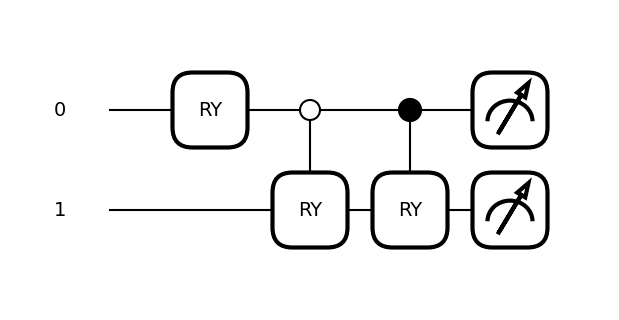

In [33]:
angles = compute_angles(build_tree(normalize_sample(x)))
state = build_circuit(angles)
qml.draw_mpl(build_circuit)(angles)

As we can see, the normalized sample $X$ was encoded into the amplitude vector of the quantum circuit after the state preparation circuit:

In [36]:
(normalize_sample(x), state)

([0.16012815380508713,
  0.48038446141526137,
  0.32025630761017426,
  -0.8006407690254357],
 array([ 0.16012815+0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.27268842+0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.35233213+0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        -0.88083033+0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j]))